In [1]:
import sys
sys.path.insert(0, 'velocitySlamSeq//slam_seq')

In [6]:
import numpy as np
from moments import moments, moments_simple
from gillespie import *
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.stats import norm as normal
import matplotlib.pyplot as plt

In [43]:
# Gillespie
params = {'a1': 20, 'b1': 20, 'a2': 20, 'b2': 20, 'K': 20, 'n': 3, 'be1': 0.5, 'ga1': 1, 'be2': 0.5, 'ga2': 1}
trajs_T, trajs_C = simulate_2bifurgenes(*list(params.values()), C0=np.zeros(4), t_span=[0, 50], n_traj=20, report=True)

Text(0.5,1,'s2')

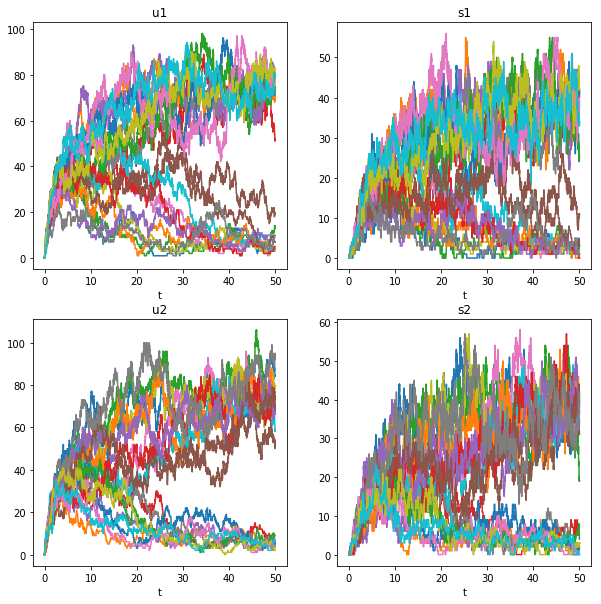

In [44]:
n_trajs = len(trajs_C)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

for i in range(n_trajs):
    ax1.plot(trajs_T[i], trajs_C[i][0, :])
    ax2.plot(trajs_T[i], trajs_C[i][1, :])
    ax3.plot(trajs_T[i], trajs_C[i][2, :])
    ax4.plot(trajs_T[i], trajs_C[i][3, :])
ax1.set_xlabel('t')
ax1.set_title('u1')
ax2.set_xlabel('t')
ax2.set_title('s1')
ax3.set_xlabel('t')
ax3.set_title('u2')
ax4.set_xlabel('t')
ax4.set_title('s2')

Text(0,0.5,'s2')

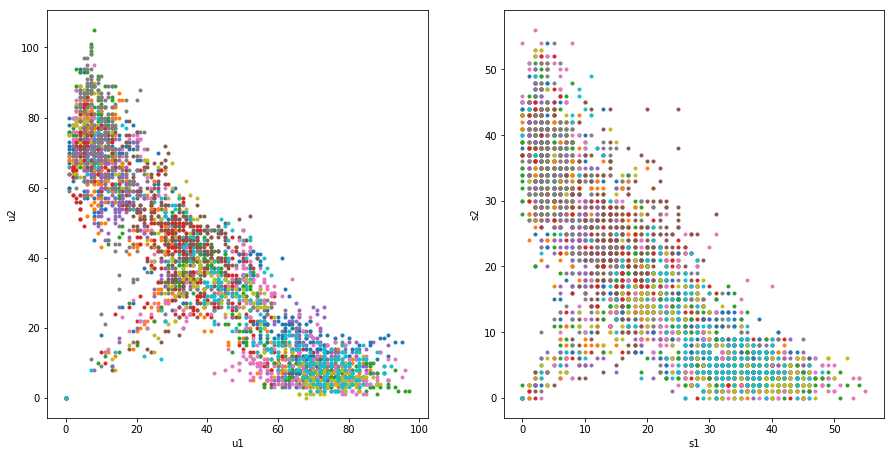

In [45]:
n_trajs = len(trajs_C)
plt.figure(figsize=(15,7.5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

for i in range(n_trajs):
    ax1.scatter(trajs_C[i][0, ::30], trajs_C[i][2, ::30], marker='.' )
    ax2.scatter(trajs_C[i][1, ::30], trajs_C[i][3, ::30], marker='.')
ax1.set_xlabel('u1')
ax1.set_ylabel('u2')
ax2.set_xlabel('s1')
ax2.set_ylabel('s2')

In [56]:
# differentiation time points
T = np.linspace(1, 45, 5)
u1 = []
u2 = []
s1 = []
s2 = []
for j in range(n_trajs):
    u1.append(np.interp(T, trajs_T[j], trajs_C[j][0, :]))
    s1.append(np.interp(T, trajs_T[j], trajs_C[j][1, :]))
    u2.append(np.interp(T, trajs_T[j], trajs_C[j][2, :]))
    s2.append(np.interp(T, trajs_T[j], trajs_C[j][3, :]))
u1 = np.array(u1).flatten()
u2 = np.array(u2).flatten()
s1 = np.array(s1).flatten()
s2 = np.array(s2).flatten()

Text(0,0.5,'s2')

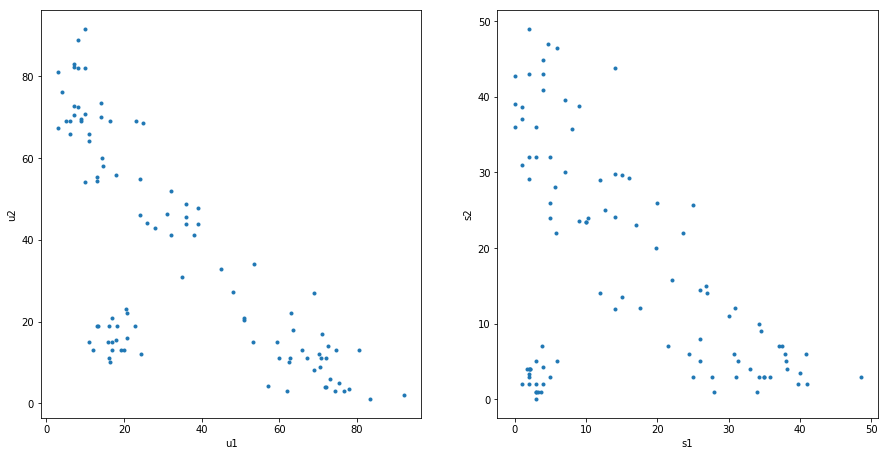

In [57]:
plt.figure(figsize=(15,7.5))
plt.subplot(1, 2, 1)
plt.scatter(u1, u2, marker='.' )
plt.xlabel('u1')
plt.ylabel('u2')

plt.subplot(1, 2, 2)
plt.scatter(s1, s2, marker='.')
plt.xlabel('s1')
plt.ylabel('s2')

In [58]:
# simulate labeling data using ODE
f_alp = lambda s1, s2, a, b, K, n : a*s1**n / (K**n + s1**n) + b*K**n / (K**n + s2**n)
f_ul = lambda t, alpha, beta : alpha/beta * (1-np.exp(-beta*t))
f_sl = lambda t, alpha, beta, gamma : alpha/gamma * (1-np.exp(-gamma*t)) + alpha/(gamma-beta) * (np.exp(-gamma*t) - np.exp(-beta*t))

In [73]:
u1_l = np.zeros((len(u1), 5))
u2_l = np.zeros((len(u2), 5))
s1_l = np.zeros((len(s1), 5))
s2_l = np.zeros((len(s2), 5))

T = np.linspace(0, 0.5, 5)
for i in range(len(u1)):
    alpha1 = f_alp(s1[i], s2[i], params['a1'], params['b1'], params['K'], params['n'])
    alpha2 = f_alp(s2[i], s1[i], params['a2'], params['b2'], params['K'], params['n'])
    u1_l[i, :] = f_ul(T, alpha1, params['be1'])
    u2_l[i, :] = f_ul(T, alpha2, params['be2'])
    s1_l[i, :] = f_sl(T, alpha1, params['be1'], params['ga1'])
    s2_l[i, :] = f_sl(T, alpha2, params['be2'], params['ga2'])


In [93]:
# k-means clustering
U = np.vstack((u1, u2))
nc = 4
kmeans = KMeans(n_clusters=nc, random_state=0).fit(U.T)
l = kmeans.labels_

Text(0,0.5,'s2')

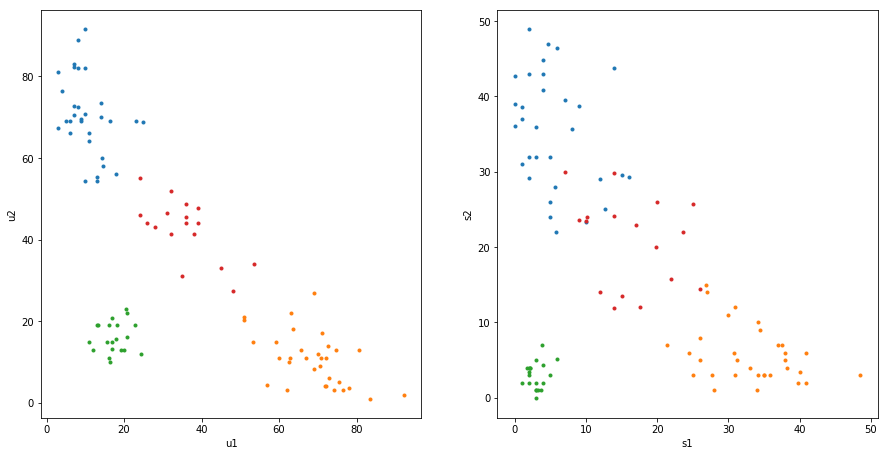

In [94]:
plt.figure(figsize=(15,7.5))
plt.subplot(1, 2, 1)
for i in range(nc):
    plt.scatter(u1[l==i], u2[l==i], marker='.' )
plt.xlabel('u1')
plt.ylabel('u2')

plt.subplot(1, 2, 2)
for i in range(nc):
    plt.scatter(s1[l==i], s2[l==i], marker='.' )
plt.xlabel('s1')
plt.ylabel('s2')

In [101]:
alps1 = np.zeros(nc)
alps2 = np.zeros(nc)
beta1 = params['be1']
beta2 = params['be2']
for i in range(nc):
    alps1[i] = np.mean(beta1 * np.mean(u1_l[l==i, 1:]) / (1-np.exp(-beta1*T[1:])))
    alps2[i] = np.mean(beta2 * np.mean(u2_l[l==i, 1:]) / (1-np.exp(-beta2*T[1:])))

In [104]:
v1 = np.zeros(u1.shape)
v2 = np.zeros(u2.shape)
for i in range(len(u1)):
    v1[i] = alps1[l[i]] - beta1 * u1[i]
    v2[i] = alps2[l[i]] - beta2 * u2[i]

Text(0,0.5,'u2')

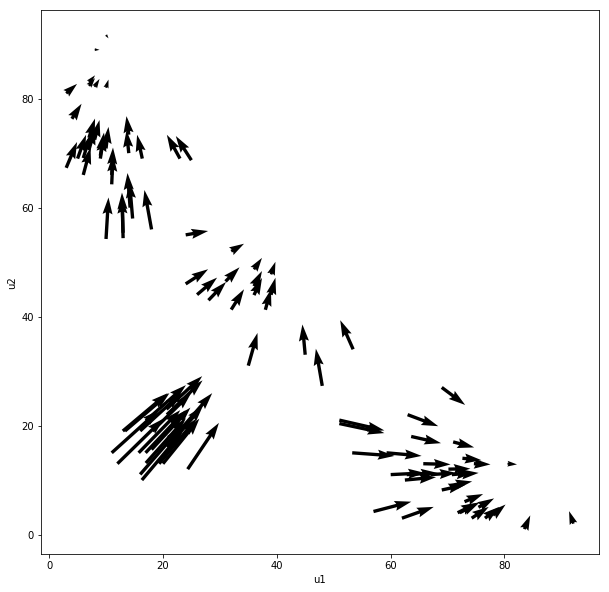

In [106]:
# velocity plot
plt.figure(figsize=(10,10))
plt.quiver(u1, u2, v1, v2)
plt.xlabel('u1')
plt.ylabel('u2')

In [136]:
# add Gaussian weights
uc = kmeans.cluster_centers_
w = np.zeros((len(u1), nc))
sig = 20
for i in range(len(u1)):
    x = np.array([u1[i], u2[i]])
    for k in range(nc):
        w[i, k] = np.exp(-(np.linalg.norm(x - uc[k]))**2/(2*sig**2))
    w[i, :] /= np.sum(w[i, :])

In [137]:
v1_g = np.zeros(u1.shape)
v2_g = np.zeros(u2.shape)
for i in range(len(u1)):
    # calculate alphas
    alp1 = np.zeros(nc)
    alp2 = np.zeros(nc)
    for j in range(nc):
        alp1[j] = alps1[j] * w[i, j]
        alp2[j] = alps2[j] * w[i, j]
    v1_g[i] = np.sum(alp1) - beta1 * u1[i]
    v2_g[i] = np.sum(alp2) - beta2 * u2[i]

Text(0,0.5,'u2')

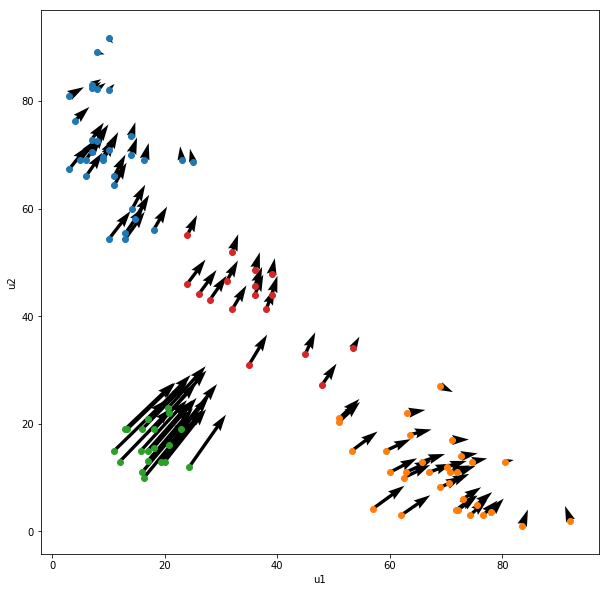

In [140]:
# velocity plot
plt.figure(figsize=(10,10))
plt.quiver(u1, u2, v1_g, v2_g)
plt.xlabel('u1')
plt.ylabel('u2')

for i in range(nc):
    plt.scatter(u1[l==i], u2[l==i], marker='o' )
plt.xlabel('u1')
plt.ylabel('u2')